# Imports

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, mannwhitneyu, shapiro, normaltest

pd.set_option('display.max_columns', None)

# Gender experiment

In [4]:
df_g = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/gender_experiment_results.csv")
df_g.head()

,seed,model,train_loss,val_f1,val_acc,val_auc,val_recall,val_precision,test_f1,test_acc,test_auc,test_recall,test_precision
0,0,A,4.039797,0.800000,0.833333,0.833333,0.666667,1.00,0.692308,0.733333,0.733333,0.600000,0.818182
1,0,B,3.085641,0.750000,0.666667,0.666667,1.000000,0.60,0.578947,0.466667,0.466667,0.733333,0.478261
2,1,A,4.576995,0.857143,0.833333,0.833333,1.000000,0.75,0.636364,0.733333,0.733333,0.466667,1.000000
3,1,B,4.749588,1.000000,1.000000,1.000000,1.000000,1.00,0.125000,0.533333,0.533333,0.066667,1.000000
4,2,A,4.932238,0.666667,0.500000,0.500000,1.000000,0.50,0.380952,0.566667,0.566667,0.266667,0.666667


In [22]:
def plot_results(df, title, custom_labels):
    # Melt validation metrics
    val_metrics = ["val_f1", "val_acc", "val_auc", "val_recall", "val_precision"]
    melted_val = df.melt(id_vars="model", value_vars=val_metrics, var_name="metric", value_name="value")

    # Melt test metrics
    test_metrics = ["test_f1", "test_acc", "test_auc", "test_recall","test_precision"]
    melted_test = df.melt(id_vars="model", value_vars=test_metrics, var_name="metric", value_name="value")

    # Create side-by-side boxplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    # Validation plot
    sns.boxplot(data=melted_val, x="metric", y="value", hue="model", ax=axes[0])
    axes[0].set_title("Validation Data Performance Metrics")
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, custom_labels, title="Model", loc="lower left")

    # Test plot
    sns.boxplot(data=melted_test, x="metric", y="value", hue="model", ax=axes[1])
    axes[1].set_title("Test Data Performance Metrics")
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles, custom_labels, title="Model", loc="lower left")

    # Adjust layout
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

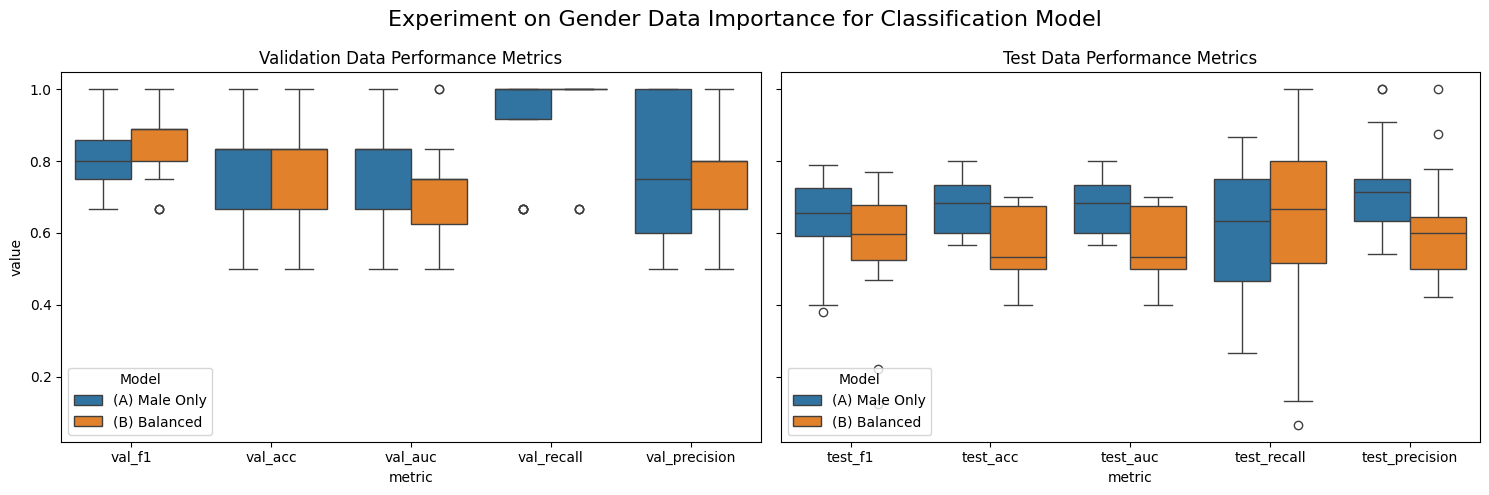

In [ ]:
plot_results(df_g,
             title="Experiment on Gender Data Importance for Classification Model",
             custom_labels=["(A) Male Only", "(B) Balanced"])


In [52]:
def compare_models_metric(df, metric_col, alpha=0.05, paired=True):
    """
    Compare performance between Model A and Model B for a specific metric column.

    Parameters:
        df (pd.DataFrame): DataFrame with columns ['model', 'seed', metric_col]
        metric_col (str): The column name to compare (e.g., 'test_f1')
        alpha (float): Significance level for statistical testing
        paired (bool): Whether to use paired statistical tests (True) or unpaired (False)

    Returns:
        None (prints results)
    """
    print(f"📊 Evaluating metric: {metric_col} | Paired: {paired}")

    if paired:
        # Pivot to align seed-wise values for paired comparison
        df_pivot = df.pivot(index="seed", columns="model", values=metric_col)
        diffs = df_pivot["A"] - df_pivot["B"]

        # Normality test on differences
        stat_sw, p_sw = shapiro(diffs)
        stat_dp, p_dp = normaltest(diffs)
        is_normal = p_sw > alpha and p_dp > alpha
        print(f"Normality assumption: {'✅ Yes' if is_normal else '❌ No'} (Shapiro p={p_sw:.4f}, D'Agostino p={p_dp:.4f})")

        # Paired tests
        if is_normal:
            t_stat, p_val = ttest_rel(df_pivot["A"], df_pivot["B"], alternative='greater')
            test_name = "Paired t-test (A > B)"
        else:
            try:
                w_stat, p_val = wilcoxon(df_pivot["A"], df_pivot["B"], alternative='greater')
                test_name = "Wilcoxon signed-rank test (A > B)"
            except ValueError as e:
                print(f"[ERROR] Wilcoxon test failed: {e}")
                return
    else:
        # Unpaired: just get values for each model
        a_vals = df[df["model"] == "A"][metric_col].values
        b_vals = df[df["model"] == "B"][metric_col].values

        # Normality test on each distribution
        stat_sw_a, p_sw_a = shapiro(a_vals)
        stat_sw_b, p_sw_b = shapiro(b_vals)
        is_normal = p_sw_a > alpha and p_sw_b > alpha
        print(f"Normality assumption: {'✅ Yes' if is_normal else '❌ No'} (Shapiro pA={p_sw_a:.4f}, pB={p_sw_b:.4f})")

        # Unpaired tests
        if is_normal:
            t_stat, p_val = ttest_ind(a_vals, b_vals, alternative='greater')
            test_name = "Unpaired t-test (A > B)"
        else:
            try:
                u_stat, p_val = mannwhitneyu(a_vals, b_vals, alternative='greater')
                test_name = "Mann-Whitney U test (A > B)"
            except ValueError as e:
                print(f"[ERROR] Mann-Whitney test failed: {e}")
                return

    # Final report
    print(f"{test_name} → p = {p_val:.4f}")
    if p_val < alpha:
        print(f"✅ Statistically significant: Model A is better at α = {alpha}")
    else:
        print(f"⚠️ Model A is NOT statistically significantly better at α = {alpha}")

In [53]:
test_metrics = ["test_f1", "test_acc", "test_auc", "test_recall","test_precision"]
for metric in test_metrics:
    compare_models_metric(df_g, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.0533, D'Agostino p=0.0577)
Paired t-test (A > B) → p = 0.0700
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.2942, D'Agostino p=0.5904)
Paired t-test (A > B) → p = 0.0009
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.2942, D'Agostino p=0.5904)
Paired t-test (A > B) → p = 0.0009
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.7786, D'Agostino p=0.8452)
Paired t-test (A > B) → p = 0.6715
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluati

In [54]:
test_metrics = ["test_f1", "test_acc", "test_auc", "test_recall","test_precision"]
for metric in test_metrics:
    compare_models_metric(df_g, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.1191, pB=0.0065)
Mann-Whitney U test (A > B) → p = 0.0797
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0949, pB=0.0324)
Mann-Whitney U test (A > B) → p = 0.0010
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0949, pB=0.0324)
Mann-Whitney U test (A > B) → p = 0.0008
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.1778, pB=0.1859)
Unpaired t-test (A > B) → p = 0.6465
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test

# Age experiments

## 40-60 age group

In [17]:
df_a_40_60 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/age_experiment_results_40_60.csv")
df_a_40_60.head()

,seed,model,train_loss,val_f1,val_acc,val_auc,val_recall,val_precision,test_f1,test_acc,test_auc,test_recall,test_precision
0,0,A,0.363617,0.50,0.6,0.583333,0.5,0.500000,0.000000,0.30,0.230769,0.000000,0.000000
1,0,B,2.127780,0.80,0.8,0.833333,1.0,0.666667,0.521739,0.45,0.543956,0.857143,0.375000
2,1,A,2.592023,1.00,1.0,1.000000,1.0,1.000000,0.000000,0.60,0.500000,0.000000,0.000000
3,1,B,1.881108,0.75,0.6,0.500000,1.0,0.600000,0.600000,0.60,0.625000,0.750000,0.500000
4,2,A,1.698861,0.80,0.8,0.833333,1.0,0.666667,0.560000,0.45,0.576923,1.000000,0.388889


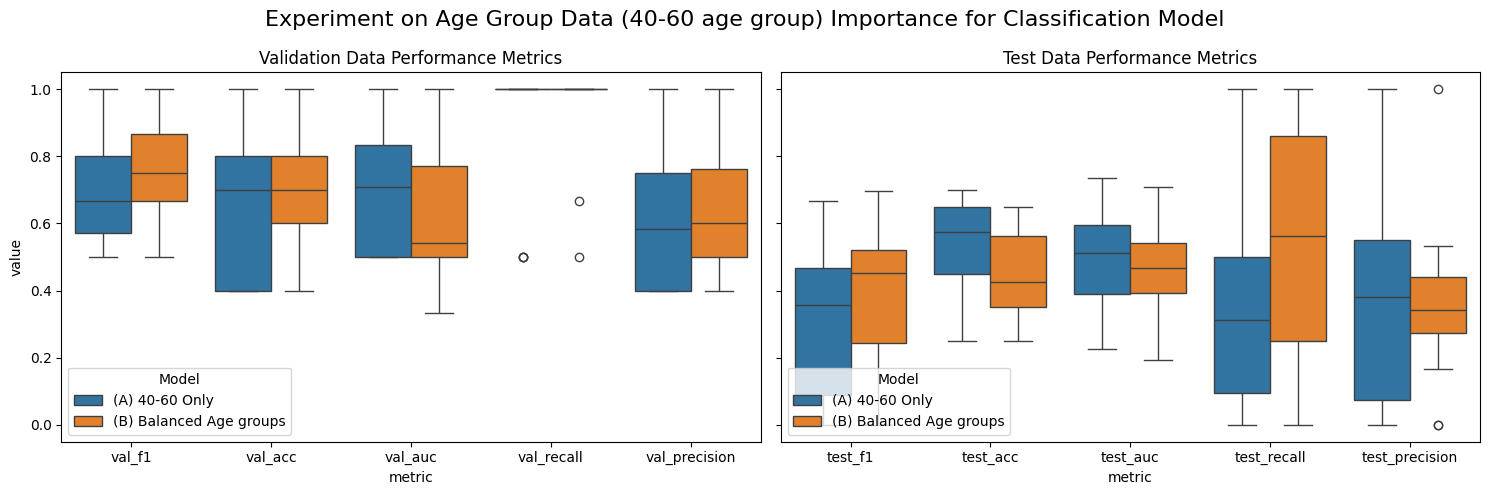

In [25]:
plot_results(df_a_40_60,
             title="Experiment on Age Group Data (40-60 age group) Importance for Classification Model",
             custom_labels=["(A) 40-60 Only", "(B) Balanced Age groups"])

In [55]:
for metric in test_metrics:
    compare_models_metric(df_a_40_60, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0209, D'Agostino p=0.1679)
Wilcoxon signed-rank test (A > B) → p = 0.8021
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.4864, D'Agostino p=0.7091)
Paired t-test (A > B) → p = 0.0282
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.3711, D'Agostino p=0.4713)
Paired t-test (A > B) → p = 0.2398
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0103, D'Agostino p=0.2522)
Wilcoxon signed-rank test (A > B) → p = 0.9900
⚠️ Model A is NOT statistically significantly better at α = 0.05
*******************

In [56]:
for metric in test_metrics:
    compare_models_metric(df_a_40_60, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.0626, pB=0.2168)
Unpaired t-test (A > B) → p = 0.8820
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.0521, pB=0.0969)
Unpaired t-test (A > B) → p = 0.0243
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.5662, pB=0.9508)
Unpaired t-test (A > B) → p = 0.2512
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0904, pB=0.0345)
Mann-Whitney U test (A > B) → p = 0.9807
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test

## 60-80 age group

In [26]:
df_a_60_80 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/age_experiment_results_60_80.csv")
df_a_60_80.head()

,seed,model,train_loss,val_f1,val_acc,val_auc,val_recall,val_precision,test_f1,test_acc,test_auc,test_recall,test_precision
0,0,A,2.548201,0.857143,0.8,0.750000,1.0,0.750000,0.774194,0.65,0.562500,1.000000,0.631579
1,0,B,1.722195,0.400000,0.4,0.416667,0.5,0.333333,0.526316,0.55,0.583333,0.416667,0.714286
2,1,A,1.104655,0.857143,0.8,0.750000,1.0,0.750000,0.750000,0.60,0.500000,1.000000,0.600000
3,1,B,2.456123,0.571429,0.4,0.500000,1.0,0.400000,0.733333,0.60,0.520833,0.916667,0.611111
4,2,A,1.171136,1.000000,1.0,1.000000,1.0,1.000000,0.640000,0.55,0.520833,0.666667,0.615385


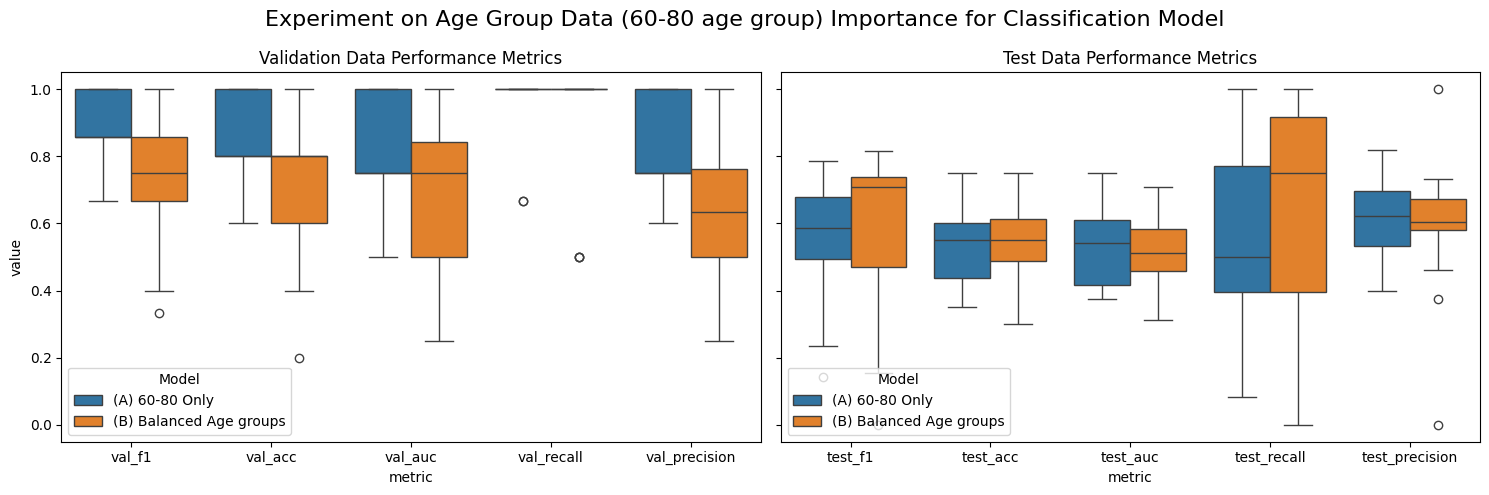

In [27]:
plot_results(df_a_60_80,
             title="Experiment on Age Group Data (60-80 age group) Importance for Classification Model",
             custom_labels=["(A) 60-80 Only", "(B) Balanced Age groups"])

In [57]:
for metric in test_metrics:
    compare_models_metric(df_a_60_80, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ❌ No (Shapiro p=0.2069, D'Agostino p=0.0202)
Wilcoxon signed-rank test (A > B) → p = 0.7848
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.0504, D'Agostino p=0.8427)
Paired t-test (A > B) → p = 0.6227
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0870, D'Agostino p=0.0266)
Wilcoxon signed-rank test (A > B) → p = 0.3474
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.5727, D'Agostino p=0.6575)
Paired t-test (A > B) → p = 0.8432
⚠️ Model A is NOT statistically significantly better at α = 0.05
*************

In [58]:
for metric in test_metrics:
    compare_models_metric(df_a_60_80, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.1582, pB=0.0016)
Mann-Whitney U test (A > B) → p = 0.7592
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.4750, pB=0.2359)
Unpaired t-test (A > B) → p = 0.6076
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.2306, pB=0.4338)
Unpaired t-test (A > B) → p = 0.3864
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.4242, pB=0.0082)
Mann-Whitney U test (A > B) → p = 0.8472
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating met

# Combined groups

## M-40-60

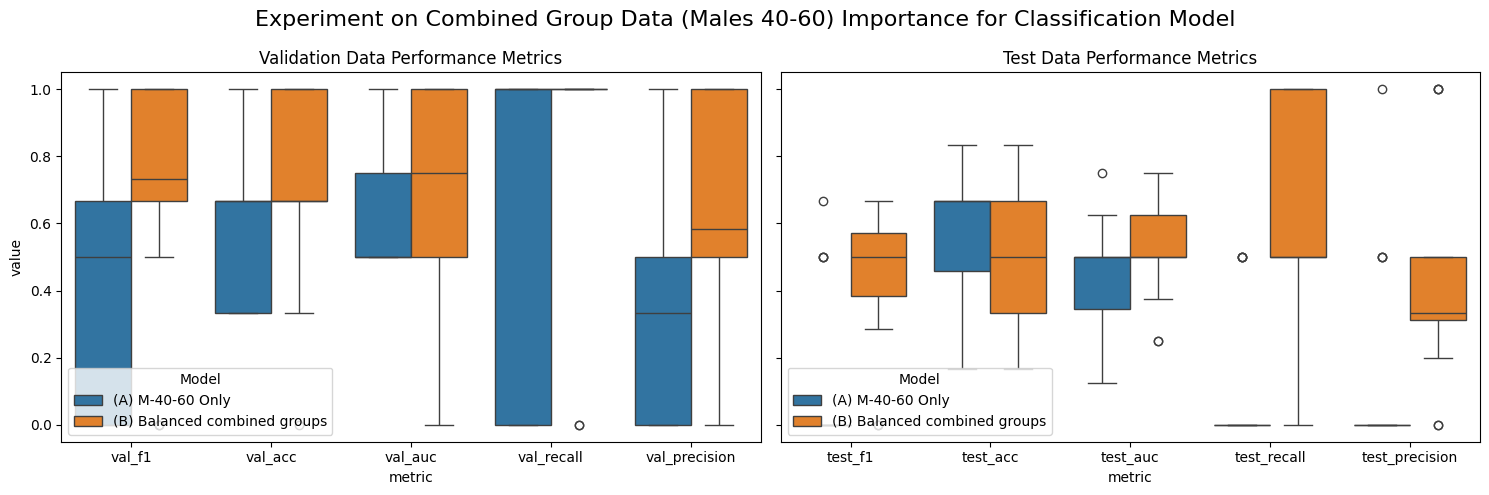

In [47]:
df_m_40_60 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/gender_age_experiment_results_40_60_M.csv")
plot_results(df_m_40_60,
             title="Experiment on Combined Group Data (Males 40-60) Importance for Classification Model",
             custom_labels=["(A) M-40-60 Only", "(B) Balanced combined groups"])

In [59]:
for metric in test_metrics:
    compare_models_metric(df_m_40_60, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0172, D'Agostino p=0.2516)
Wilcoxon signed-rank test (A > B) → p = 0.9996
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.0651, D'Agostino p=0.1182)
Paired t-test (A > B) → p = 0.2225
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.3018, D'Agostino p=0.9217)
Paired t-test (A > B) → p = 0.9599
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0013, D'Agostino p=0.5652)
Wilcoxon signed-rank test (A > B) → p = 0.9999
⚠️ Model A is NOT statistically significantly better at α = 0.05
*************

In [60]:
for metric in test_metrics:
    compare_models_metric(df_m_40_60, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0000, pB=0.0055)
Mann-Whitney U test (A > B) → p = 1.0000
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0004, pB=0.0387)
Mann-Whitney U test (A > B) → p = 0.1716
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0471, pB=0.0567)
Mann-Whitney U test (A > B) → p = 0.9674
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0000, pB=0.0004)
Mann-Whitney U test (A > B) → p = 1.0000
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluati

## F-40-60

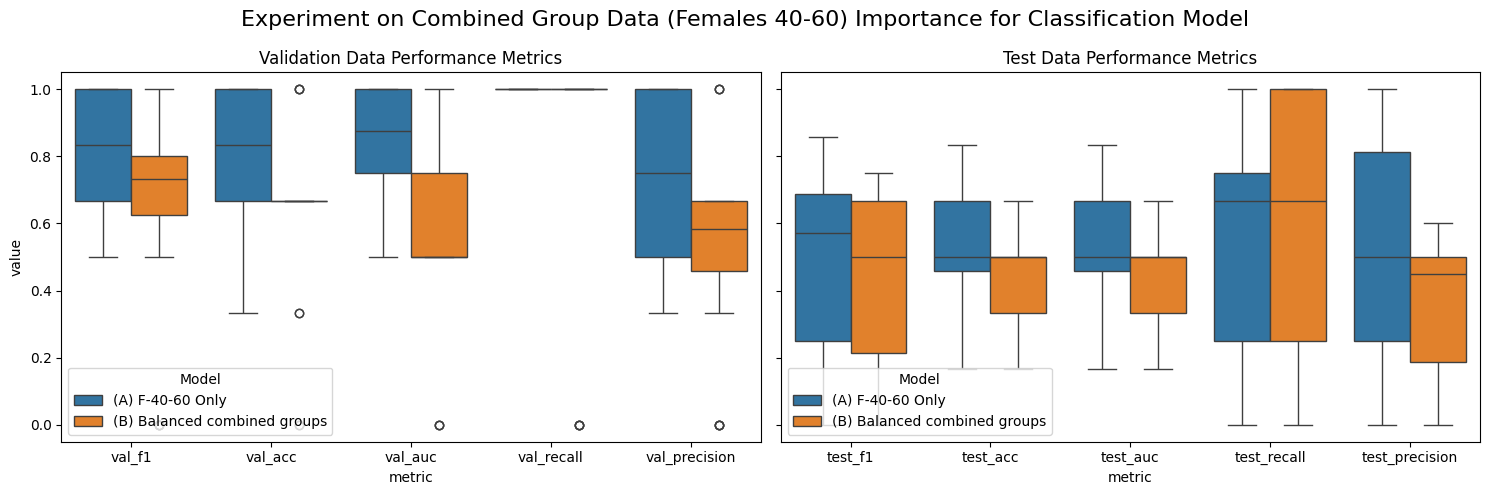

In [49]:
df_f_40_60 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/gender_age_experiment_results_40_60_F.csv")
plot_results(df_f_40_60,
             title="Experiment on Combined Group Data (Females 40-60) Importance for Classification Model",
             custom_labels=["(A) F-40-60 Only", "(B) Balanced combined groups"])

In [61]:
for metric in test_metrics:
    compare_models_metric(df_f_40_60, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.2820, D'Agostino p=0.2783)
Paired t-test (A > B) → p = 0.1986
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0264, D'Agostino p=0.3972)
Wilcoxon signed-rank test (A > B) → p = 0.0167
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0264, D'Agostino p=0.3972)
Wilcoxon signed-rank test (A > B) → p = 0.0169
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0274, D'Agostino p=0.2361)
Wilcoxon signed-rank test (A > B) → p = 0.6595
⚠️ Model A is NOT statistically significantly better at α = 0.05
**************

In [62]:
for metric in test_metrics:
    compare_models_metric(df_f_40_60, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0040, pB=0.0032)
Mann-Whitney U test (A > B) → p = 0.1677
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0768, pB=0.0015)
Mann-Whitney U test (A > B) → p = 0.0214
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0768, pB=0.0015)
Mann-Whitney U test (A > B) → p = 0.0230
✅ Statistically significant: Model A is better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0078, pB=0.0025)
Mann-Whitney U test (A > B) → p = 0.6262
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: t

## M-60-80

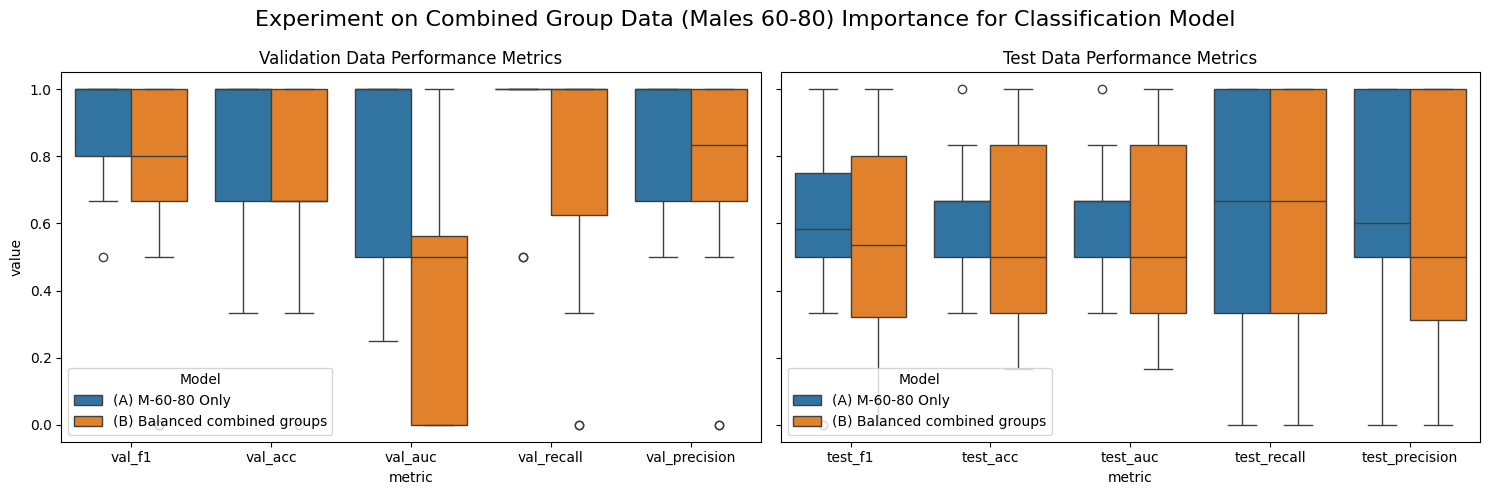

In [63]:
df_m_60_80 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/gender_age_experiment_results_60_80_M.csv")
plot_results(df_m_60_80,
             title="Experiment on Combined Group Data (Males 60-80) Importance for Classification Model",
             custom_labels=["(A) M-60-80 Only", "(B) Balanced combined groups"])

In [64]:
for metric in test_metrics:
    compare_models_metric(df_m_60_80, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.7624, D'Agostino p=0.9599)
Paired t-test (A > B) → p = 0.3329
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0311, D'Agostino p=0.1243)
Wilcoxon signed-rank test (A > B) → p = 0.5609
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0311, D'Agostino p=0.1243)
Wilcoxon signed-rank test (A > B) → p = 0.4045
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.3970, D'Agostino p=0.5619)
Paired t-test (A > B) → p = 0.3456
⚠️ Model A is NOT statistically significantly better at α = 0.05
*************

In [65]:
for metric in test_metrics:
    compare_models_metric(df_m_60_80, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.2799, pB=0.0534)
Unpaired t-test (A > B) → p = 0.3140
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.0645, pB=0.0529)
Unpaired t-test (A > B) → p = 0.4071
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ✅ Yes (Shapiro pA=0.0645, pB=0.0529)
Unpaired t-test (A > B) → p = 0.4071
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0017, pB=0.0029)
Mann-Whitney U test (A > B) → p = 0.3671
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric

## F-60-80

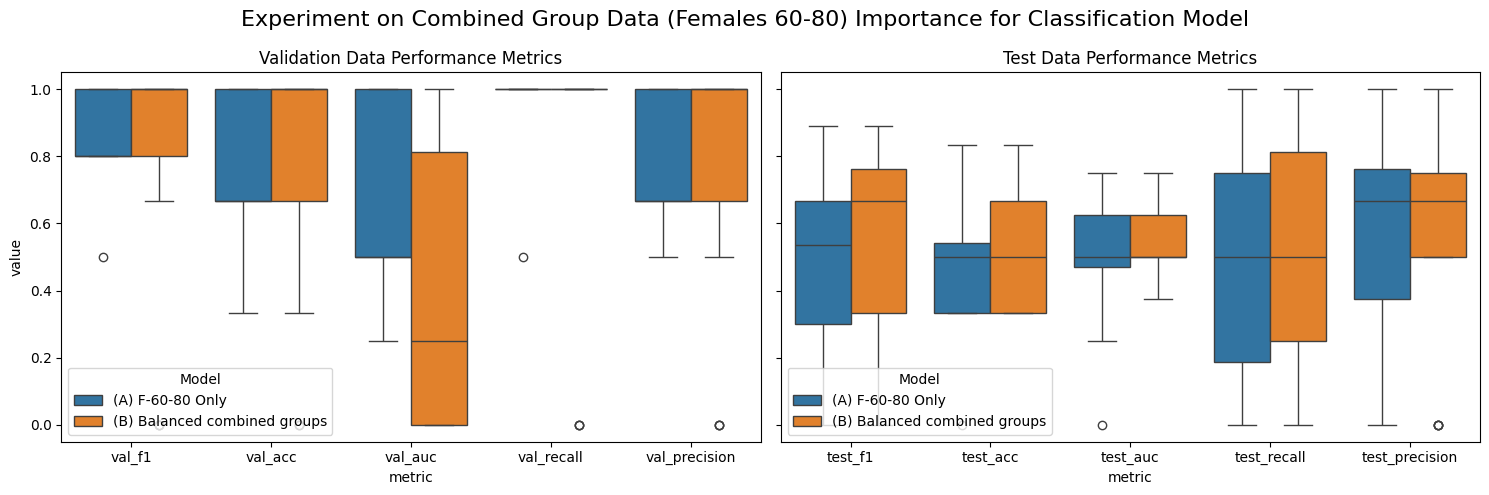

In [66]:
df_f_60_80 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/gender_age_experiment_results_60_80_F.csv")
plot_results(df_f_60_80,
             title="Experiment on Combined Group Data (Females 60-80) Importance for Classification Model",
             custom_labels=["(A) F-60-80 Only", "(B) Balanced combined groups"])

In [67]:
for metric in test_metrics:
    compare_models_metric(df_f_60_80, metric, alpha=0.05, paired=True)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.7100, D'Agostino p=0.8109)
Paired t-test (A > B) → p = 0.7339
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.2131, D'Agostino p=0.8449)
Paired t-test (A > B) → p = 0.8572
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: True
Normality assumption: ❌ No (Shapiro p=0.0257, D'Agostino p=0.0111)
Wilcoxon signed-rank test (A > B) → p = 0.7050
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: True
Normality assumption: ✅ Yes (Shapiro p=0.2460, D'Agostino p=0.6469)
Paired t-test (A > B) → p = 0.7883
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************

In [68]:
for metric in test_metrics:
    compare_models_metric(df_f_60_80, metric, alpha=0.05, paired=False)
    print("************************************")

📊 Evaluating metric: test_f1 | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0115, pB=0.0030)
Mann-Whitney U test (A > B) → p = 0.8343
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_acc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0454, pB=0.0043)
Mann-Whitney U test (A > B) → p = 0.8392
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_auc | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0253, pB=0.0043)
Mann-Whitney U test (A > B) → p = 0.6125
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluating metric: test_recall | Paired: False
Normality assumption: ❌ No (Shapiro pA=0.0454, pB=0.0192)
Mann-Whitney U test (A > B) → p = 0.8193
⚠️ Model A is NOT statistically significantly better at α = 0.05
************************************
📊 Evaluati